In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
def MeanPositiveError(truth, prediction):
    error = prediction - truth
    error = error[error >= 0]
    return np.sum(error)/np.shape(truth)[0]

# Analyzing Zip decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - Files/folders compressed in zip files have metadata about uncompressed size. How accurate is this?
 - How much of an improvement is estimation vs. decompression?

**Note: Estimation
refers to utilizing the `ZipInfo` object from the `zipfile` library to retrieve uncompressed file size from file headers** 

In [3]:
# Import decompression size .csv
zip_results_df = pd.read_csv("../data/zip_decompression_results.csv")

In [4]:
# Summarise data
print(f"{zip_results_df.describe()}\n")

print(f"Compression types: {set(zip_results_df.compression_type)}\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     1.683000e+03       1.683000e+03     1.683000e+03       1683.000000   
mean      5.187461e+07       2.843337e+08     2.843337e+08          7.957219   
std       1.638857e+08       1.504371e+09     1.504371e+09          0.583625   
min       3.505000e+03       1.207600e+04     1.207600e+04          0.000000   
25%       2.008875e+05       6.005115e+05     6.005115e+05          8.000000   
50%       1.860042e+06       5.854283e+06     5.854283e+06          8.000000   
75%       2.330739e+07       7.440141e+07     7.440141e+07          8.000000   
max       1.835963e+09       3.012582e+10     3.012582e+10          8.000000   

       decompression_time  estimation_time  
count         1683.000000      1683.000000  
mean             2.052280         0.000457  
std             10.689081         0.004518  
min              0.000489         0.000079  
25%              0.034683         0.000162  
50%      

In [6]:
print(zip_results_df[zip_results_df.estimated_value > 2**32])

                                              file_name  compressed_size  \
661   58ab2dab_Pacific_current_30arcsec_generic_set3...        334341837   
673   a1086e6f_Pacific_current_30arcsec_generic_set2...        610354706   
679   d872ee58_Pacific_current_30arcsec_generic_set1...        625760978   
680   081c6f5c_elev_global_current_30arcsec_generic.zip        765681794   
688   c009c985_NewWorld_current_30arcsec_generic_set...        413145453   
702   4db078b3_NewWorld_current_30arcsec_generic_set...        431375841   
707   eaee3452_global_current_30arcsec_generic_set3.zip        762039276   
711   2d1fdd89_Pacific_current_30arcsec_generic_set4...        810564350   
715   0060a953_NewWorld_current_30arcsec_generic_set...        557690241   
785                              a4b82c05_nlcd92arc.zip       1835962728   
888                              5278a22f_nlcd92img.zip       1280034084   
1120                               f405e5ab_glc2000.zip        108005044   
1258        

Best fit line: 5.888360664541447x + -21122719.68894244
RMSE: [1.15372418e+09]
Mean positive error: 124010328.5615838


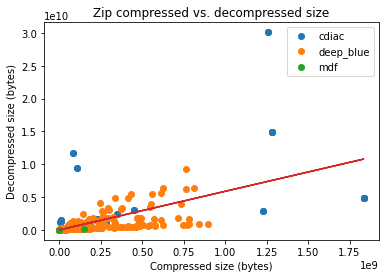

In [5]:
# Visualize compression vs. decompression
x1 = zip_results_df.compressed_size
y1 = zip_results_df.decompressed_size

# Figure 1
for name, group in zip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)

plt.plot(x1, poly_fn(x1))

plt.legend()
plt.title("Zip compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")
print(f"Mean positive error: {MeanPositiveError(y1, poly_fn(x1))}")

Line of best fit: 0.9613492288946763x + 0.783012810090921
RMSE: [0.3638623]


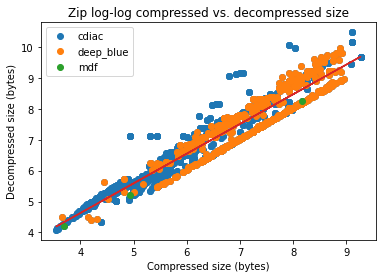

In [6]:
# Figure 2
for name, group in zip_results_df.groupby("origin"):
    plt.plot(np.log10(group.compressed_size), 
             np.log10(group.decompressed_size), marker="o", linestyle="", label=name)

plt.scatter(np.log10(x1), np.log10(y1))
exp_coef, res, _, _, _ = np.polyfit(np.log10(x1), np.log10(y1), 1, full=True)
exp_poly_fn = np.poly1d(exp_coef)

plt.plot(np.log10(x1), exp_poly_fn(np.log10(x1)))

plt.legend()
plt.title("Zip log-log compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

print(f"Line of best fit: {exp_coef[0]}x + {exp_coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

Text(0, 0.5, 'Number of files')

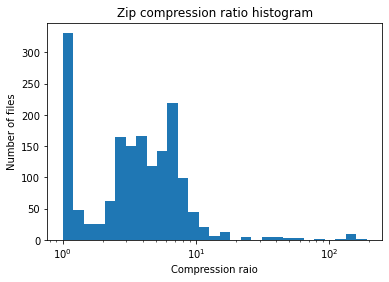

In [7]:
# Visualize compression ratios
compression_ratios = zip_results_df.decompressed_size / zip_results_df.compressed_size

# Figure 3
bins = np.logspace(0,np.log10(max(compression_ratios)), 30)
plt.hist(compression_ratios, bins=bins)

plt.title("Zip compression ratio histogram")
plt.xscale("log")
plt.xlabel("Compression raio")
plt.ylabel("Number of files")

Best fit line: 0.9999999981677833x + 15.123456820046426


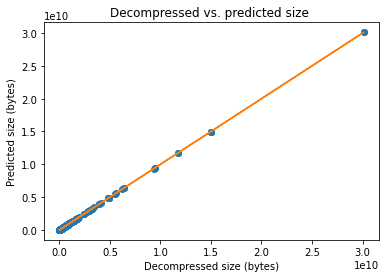

In [8]:
# Visualize actual decompression size vs. predicted size
x2 = zip_results_df.decompressed_size
y2 = zip_results_df.estimated_value

coef = np.polyfit(x2, y2, 1)
poly_fn = np.poly1d(coef)

# Figure 4
plt.plot(x2, y2,"o", x2,  
         poly_fn(x2))

plt.title("Decompressed vs. predicted size ")
plt.xlabel("Decompressed size (bytes)")
plt.ylabel("Predicted size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")

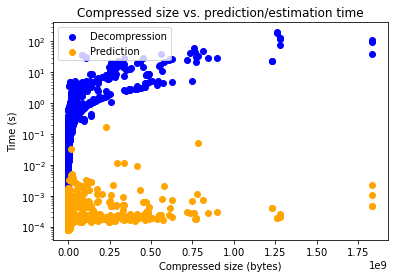

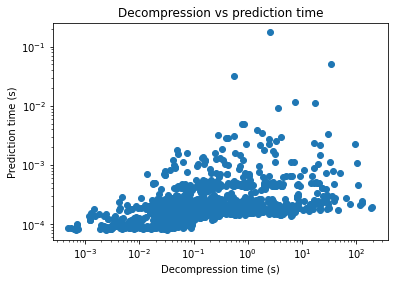

In [9]:
# Visualize compressed size vs. decompression time

x3 = zip_results_df.compressed_size
y3 = zip_results_df.decompression_time
y3_2 = zip_results_df.estimation_time

# Figure 5
plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")

plt.title("Compressed size vs. prediction/estimation time")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.yscale("log")
plt.show()

# Figure 6
plt.scatter(y3, y3_2)

plt.title("Decompression vs prediction time")
plt.xlabel("Decompression time (s)")
plt.ylabel("Prediction time (s)")
plt.xscale("log")
plt.yscale("log")

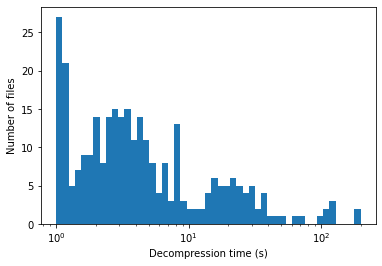

In [10]:
# Visualize decompression and prediction time distributions

# Figure 7
bins = np.logspace(0,np.log10(max(y3)), 50)
plt.hist(y3, bins=bins)

plt.xscale("log")
plt.ylabel("Number of files")
plt.xlabel("Decompression time (s)")
plt.show()

## Analysis Results:
- The relationship between compressed size and decompressed size looks to be **linear**. Figure 1 shows a line of best fit with RMSE of ~1e9 or 1GB, and figure 2 shows a log-log plot with slope ~1, confirming the linear relationship.
- Estimation is a **100%** accurate method for determining the final size of decompressed zip files. Figure 4 shows that the the equation of estimated decompressed size vs. true decompressed size is y=x.
- As shown by Figure 5, estimation is **orders of magnitude faster** than decompression.

## Conclusion:
The relationship between the comprsesed and decompressed size of zip files is highly linear. A linear regression fit on the data has a RMSE of ~1e9 or 1GB. Simply estimating the decompressed size using `ZipInfo` is far more accurate and much faster. However, this may not be possible depending on the features given.

# Analyzing Tar decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - Files/folders compressed in zip files have metadata about uncompressed size. How accurate is this?
 - How much of an improvement is estimation vs. decompression?

**Note: Estimation refers to utilizing the `TarInfo` object from the `tarfile` library to retrieve uncompressed file size from file headers** 

In [11]:
# Import decompression size .csv
tar_results_df = pd.read_csv("../data/tar_decompression_results.csv")

In [12]:
# Data cleaning
tar_results_df = tar_results_df[(tar_results_df.decompressed_size != 0) & (tar_results_df.compressed_size != 0)]

In [13]:
# Summarise data
print(f"{tar_results_df.describe()}\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     3.470000e+02       3.470000e+02     3.470000e+02               0.0   
mean      2.341387e+08       6.255697e+08     6.255634e+08               NaN   
std       1.623027e+09       5.258325e+09     5.258326e+09               NaN   
min       3.569000e+03       1.633400e+04     1.633400e+04               NaN   
25%       1.433303e+06       7.882262e+06     7.882262e+06               NaN   
50%       5.194968e+06       2.720590e+07     2.720590e+07               NaN   
75%       4.455424e+07       1.608570e+08     1.608570e+08               NaN   
max       2.083467e+10       6.875089e+10     6.875089e+10               NaN   

       decompression_time  estimation_time  
count          347.000000       347.000000  
mean             9.189483         3.749308  
std            100.669668        42.328700  
min              0.000880         0.000373  
25%              0.015260         0.000651  
50%      

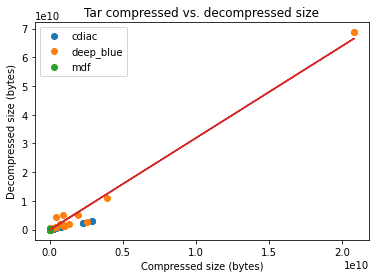

Best fit line: 3.2019982359283707x + -124141932.93558002
RMSE: [8.00039117e+08]


In [14]:
# Visualize compression vs. decompression
x1 = tar_results_df.compressed_size
y1 = tar_results_df.decompressed_size

# Figure 1
for name, group in tar_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
    
plt.plot(x1, poly_fn(x1))

plt.legend()
plt.title("Tar compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")
plt.show()

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

Line of best fit: 0.7785371067581165x + 2.0863532101335713
RMSE: [0.51498565]


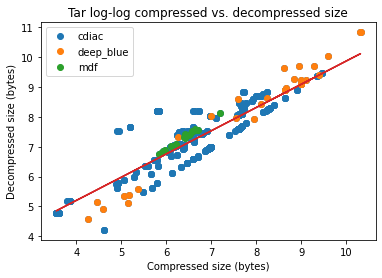

In [15]:
# Figure 2
for name, group in tar_results_df.groupby("origin"):
    plt.plot(np.log10(group.compressed_size), 
             np.log10(group.decompressed_size), marker="o", linestyle="", label=name)

plt.scatter(np.log10(x1), np.log10(y1))
exp_coef, res, _, _, _ = np.polyfit(np.log10(x1), np.log10(y1), 1, full=True)
exp_poly_fn = np.poly1d(exp_coef)

plt.plot(np.log10(x1), exp_poly_fn(np.log10(x1)))

plt.legend()
plt.title("Tar log-log compressed vs. decompressed size")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")

print(f"Line of best fit: {exp_coef[0]}x + {exp_coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

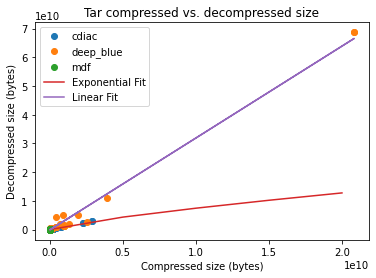

Exponential line of best fit: 10^(0.7785371067581165 * log10(x) + 2.0863532101335713)
Exponential line RMSE: 4252326559.1499124
Exponention line mean positive error: 18596846.449825734
Linear line of best fit:  
3.202 x - 1.241e+08
Linear line RMSE: [8.00039117e+08]
Linear mean positive error: 152182143.0292566


In [16]:
# Figure 3
for name, group in tar_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)
    
exp_coef = np.polyfit(np.log10(x1), np.log10(y1), 1)
exp_poly_fn = np.poly1d(exp_coef)
exp_fn = lambda x: np.power(10, exp_poly_fn(np.log10(x)))

plt.plot(np.array([i for i in range(1, 25*10**9, 5*10**9)]), 
         exp_fn(np.array([i for i in range(1, 25*10**9, 5*10**9)])), label="Exponential Fit")

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
plt.plot(x1, poly_fn(x1), label="Linear Fit")

plt.title("Tar compressed vs. decompressed size")
plt.legend()
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Decompressed size (bytes)")
plt.show()

print(f"Exponential line of best fit: 10^({exp_coef[0]} * log10(x) + {exp_coef[1]})")
print(f"Exponential line RMSE: {np.sqrt((sum(abs(y1 - exp_fn(x1)) ** 2))/len(x1))}")
print(f"Exponention line mean positive error: {MeanPositiveError(y1, exp_fn(x1))}")

print(f"Linear line of best fit: {poly_fn}")
print(f"Linear line RMSE: {np.sqrt(res/len(x1))}")
print(f"Linear mean positive error: {MeanPositiveError(y1, poly_fn(x1))}")

Best fit line: 1.0000001222670083x + -6339.428896352482
Estimation RMSE: 116495.69315055307


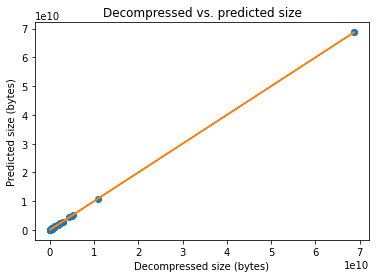

In [17]:
# Visualize actual decompression size vs. predicted size
x2 = tar_results_df.decompressed_size
y2 = tar_results_df.estimated_value

idx = np.isfinite(x2) & np.isfinite(y2)

coef, res, _, _, _ = np.polyfit(x2[idx], y2[idx], 1, full=True)
poly_fn = np.poly1d(coef)

# Figure 4
plt.plot(x2, y2,"o", x2,  
         poly_fn(x2))

plt.title("Decompressed vs. predicted size")
plt.xlabel("Decompressed size (bytes)")
plt.ylabel("Predicted size (bytes)")

print(f"Best fit line: {coef[0]}x + {coef[1]}")
print(f"Estimation RMSE: {np.sqrt(sum(abs(y2 - poly_fn(x2))**2)/len(x2))}")

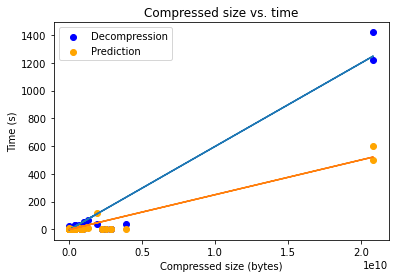

Decompression time best fit line: 6.022034190819615e-08x + -4.910427903575035
Decompression line RMSE: [24.07801178]
Estimation time best fit line: 2.5124981570385543e-08x + -2.133421263464182
Estimation line RMSE: [11.33402782]


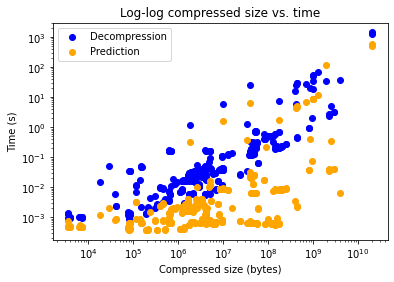

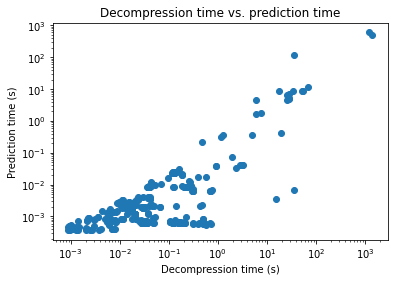

In [18]:
# Visualize compressed size vs. decompression time

x3 = tar_results_df.compressed_size
y3 = tar_results_df.decompression_time
y3_2 = tar_results_df.estimation_time

# Figure 5
idx = np.isfinite(x3) & np.isfinite(y3)

decompression_coef, decompression_res, _, _, _ = np.polyfit(x3[idx], y3[idx], 1, full=True)
decompression_poly_fn = np.poly1d(decompression_coef)

idx = np.isfinite(x3) & np.isfinite(y3_2)
estimation_coef, estimation_res, _, _, _ = np.polyfit(x3[idx], y3_2[idx], 1, full=True)
estimation_poly_fn = np.poly1d(estimation_coef)

plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")
plt.plot(x3, decompression_poly_fn(x3))
plt.plot(x3, estimation_poly_fn(x3))

plt.title("Compressed size vs. time")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.legend(loc="upper left")
plt.show()

print(f"Decompression time best fit line: {decompression_coef[0]}x + {decompression_coef[1]}")
print(f"Decompression line RMSE: {np.sqrt(decompression_res/len(x3))}")
print(f"Estimation time best fit line: {estimation_coef[0]}x + {estimation_coef[1]}")
print(f"Estimation line RMSE: {np.sqrt(estimation_res/len(x3))}")

# Figure 6
plt.scatter(x3, y3, color="blue", label="Decompression")
plt.scatter(x3, y3_2, color="orange", label="Prediction")

plt.legend()
plt.title("Log-log compressed size vs. time")
plt.xlabel("Compressed size (bytes)")
plt.ylabel("Time (s)")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Figure 7
plt.scatter(y3, y3_2)

plt.title("Decompression time vs. prediction time")
plt.xlabel("Decompression time (s)")
plt.ylabel("Prediction time (s)")
plt.xscale("log")
plt.yscale("log")

## Analysis Results
- The relationship between compressed vs. decompressed size seems to be **linear**.
- Figure 2 shows an even clearer linear relationship in a log-log plot, with a slope of ~1, confirming that compressed vs. decompressed size has a linear relationship. A linear regression shows a RMSE of ~8e8, or 800MB. However, many of the data points are located at extremes, so additional data will be needed to confirm this regression.
- Figure 4 shows that estimation is a **near perfect** match of the true value. The RMSE of the line of best fit is ~500KB. However, further analysis shows that any error from the line of best fit occurs from one singular point, where estimation underestimated the size of a file by ~2MB, potentially due non-negligible folder sizes not counted when the decompressed size was calculated. 
- Figure 6 shows that estimation is **almost always faster** that decompression, with a linear-looking relation. However, similar to Figures 1 and 2, Figure 5 shows a much stronger linear relation on a log-log plot, indicating another potential polynomial relationship. Many of the estimation times are in the tens or in the hundreds of seconds. Estimation relies on performing a linear scan of the file without decompressing, so it is highly unlikely that this can be parallelized for faster performance. Therefore, for the sake of performance, it may be necessary to create a prediction model. 

## Conclusion
Unlike the estimation of zip file decompressed size, tar file decompressed size is considerably more costly with little hope of being able to be parallelized. Although estimation is a near perfect estimate of decompressed size, there is a massive time tradeoff. In order to find a middleground betweeen accuracy and time, an external polynomial or linear regression may be needed. At this time, decompressed size can be predicted somewhat accurately using a quartic regression. More data will be needed to confirm this relationship and to create a more accurate regression.

# Analyzing Gzip decompression

Points of interest to analyze:
 - What is the relationship between compressed and decompressed size?
 - What are the file extensions of the decompressed files?

In [19]:
# Import decompression size .csv
gzip_results_df = pd.read_csv("../data/gzip_decompression_results.csv")

In [20]:
# Data cleaning
gzip_results_df = gzip_results_df[(gzip_results_df.decompressed_size != 0) & (gzip_results_df.compressed_size != 0)]

In [21]:
# Summarise data
print(f"{gzip_results_df.describe()}\n")

       compressed_size  decompressed_size  estimated_value  compression_type  \
count     1.575000e+03       1.575000e+03              0.0               0.0   
mean      2.491248e+07       9.018550e+07              NaN               NaN   
std       1.801933e+08       5.373120e+08              NaN               NaN   
min       3.569000e+03       5.120000e+04              NaN               NaN   
25%       1.610198e+06       6.653474e+06              NaN               NaN   
50%       1.701805e+06       7.015383e+06              NaN               NaN   
75%       3.939589e+06       1.870362e+07              NaN               NaN   
max       4.034568e+09       1.244493e+10              NaN               NaN   

       decompression_time  estimation_time  
count         1575.000000              0.0  
mean             1.030397              NaN  
std             10.999297              NaN  
min              0.000424              NaN  
25%              0.039162              NaN  
50%      

In [22]:
# Visualize compression vs. decompression
x1 = gzip_results_df.compressed_size
y1 = gzip_results_df.decompressed_size

Line of best fit: 2.7473421949263925x + 21742394.33076868
RMSE: [2.08804663e+08]


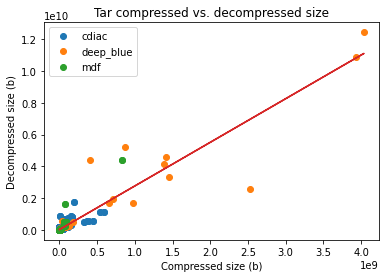

In [23]:
# Figure 1 (Decompressed vs. Compressed size (Linear scale))
for name, group in gzip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)
    
coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)

plt.plot(x1, poly_fn(x1))

plt.legend()
plt.title("Tar compressed vs. decompressed size")
plt.xlabel("Compressed size (b)")
plt.ylabel("Decompressed size (b)")

print(f"Line of best fit: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

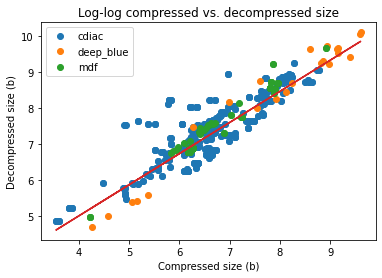

Line of best fit: 0.8624421386414901x + 1.5561607454870847
RMSE: [0.31394798]


In [24]:
# Figure 2 (Decompressed (b) vs. Compressed size (b) (Log10 scale))
for name, group in gzip_results_df.groupby("origin"):
    plt.plot(np.log10(group.compressed_size), 
             np.log10(group.decompressed_size), marker="o", linestyle="", label=name)

coef, res, _, _, _ = np.polyfit(np.log10(x1), np.log10(y1), 1, full=True)
poly_fn = np.poly1d(coef)

plt.plot(np.log10(x1), poly_fn(np.log10(x1)))

plt.title("Log-log compressed vs. decompressed size")
plt.xlabel("Compressed size (b)")
plt.ylabel("Decompressed size (b)")
plt.legend()
plt.show()

print(f"Line of best fit: {coef[0]}x + {coef[1]}")
print(f"RMSE: {np.sqrt(res/len(x1))}")

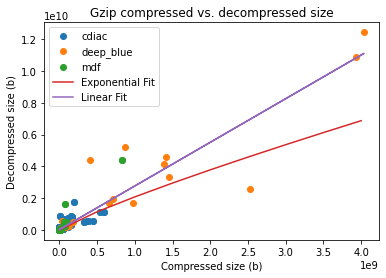

Exponential line of best fit: 10^(0.8624421386414901 * log10(x) + 1.5561607454870847)
Exponential line RMSE: 265165043.96465358
Exponention line mean positive error: 7577436.675662487
Linear line of best fit:  
2.747 x + 2.174e+07
Linear line RMSE: [2.08804663e+08]
Linear mean positive error: 25645869.288201053


In [25]:
# Figure 3 (Decompressed vs. Compressed size (Linear scale))
for name, group in gzip_results_df.groupby("origin"):
    plt.plot(group.compressed_size, group.decompressed_size, marker="o", linestyle="", label=name)

exp_coef = np.polyfit(np.log10(x1), np.log10(y1), 1)
exp_poly_fn = np.poly1d(exp_coef)
exp_fn = lambda x: np.power(10, exp_poly_fn(np.log10(x)))
plt.plot(np.array([i for i in range(1, 45*10**8, 5*10**8)]), 
         exp_fn(np.array([i for i in range(1, 45*10**8, 5*10**8)])), label="Exponential Fit")

coef, res, _, _, _ = np.polyfit(x1, y1, 1, full=True)
poly_fn = np.poly1d(coef)
plt.plot(x1, poly_fn(x1), label="Linear Fit")

plt.title("Gzip compressed vs. decompressed size")
plt.xlabel("Compressed size (b)")
plt.ylabel("Decompressed size (b)")
plt.legend()
plt.show()

print(f"Exponential line of best fit: 10^({exp_coef[0]} * log10(x) + {exp_coef[1]})")
print(f"Exponential line RMSE: {np.sqrt((sum(abs(y1 - exp_fn(x1)) ** 2))/len(x1))}")
print(f"Exponention line mean positive error: {MeanPositiveError(y1, exp_fn(x1))}")

print(f"Linear line of best fit: {poly_fn}")
print(f"Linear line RMSE: {np.sqrt(res/len(x1))}")
print(f"Linear mean positive error: {MeanPositiveError(y1, poly_fn(x1))}")

## Analysis Results
- As shown in Figure 1, it appears that decompressed and compressed size have a linear relationship. This is additionally supported by the fact that the log-log plot in Figure 2 has a slope of ~1. 
- Figure 3 shows that a linear line produces a lower RMSE than an exponential curve. However, the RMSE of the linear regression is ~1.3e9, or 1.3GB. Considering that these decompressed file sizes range from 0-12GB, an average error of 1.3GB is rather significant. More data points will be necessary to fit a better predictor.